# Identifikation von Texten mit geteilter Autorenschaft

## Data Exploration: booksummaries

Basic data exploration of the booksummaries dataset.

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Loading the data
data = pd.read_csv(
    './datasets/booksummaries/booksummaries.txt', 
    header=None,
    sep='\t',
    names=['wiki_id', 'firebase_id', 'title', 'author', 'pub_date', 'genres', 'plot']
)
data.head()

,wiki_id,firebase_id,title,author,pub_date,genres,plot
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


In [4]:
# Number of entries
data.shape

(16559, 7)

In [5]:
# Entries are unique books by ids...
print("Unique Wikipedia IDs:\t", data.wiki_id.unique().size)
print("Unique Firebase IDs:\t", data.firebase_id.unique().size)
# ...but not by title
print("Unique Titles:\t\t", data.title.unique().size)

Unique Wikipedia IDs:	 16559
Unique Firebase IDs:	 16559
Unique Titles:		 16277


In [6]:
# We have some missing values
data.isnull().sum()

wiki_id           0
firebase_id       0
title             0
author         2382
pub_date       5610
genres         3718
plot              0
dtype: int64

### Extracting Genres

In [7]:
# Subset original data
temp = data.loc[:, ['wiki_id', 'genres']]
# drop rows without genres
temp = temp.dropna()
# extract `id: genre` pairs to lists
temp.genres = temp.genres.str.replace('[{}"]', '', regex=True).str.split(', ')
# map each genre <=> book relation to a seperate row
genre_tags = []
for key, row in temp.iterrows():
    book_id = row[0]
    tags = pd.Series(row[1]).str.split(': ')
    for genre_id, genre_name in tags:
        genre_tags += [[book_id, genre_id, genre_name]]


genre_tags = pd.DataFrame(genre_tags)
genre_tags.columns = ['wiki_id', 'genre_id', 'genre_name']

In [8]:
# Extract unique genres
genres = genre_tags.loc[:,['genre_id', 'genre_name']].drop_duplicates()
genres.describe() # Note that there are more unique ids than names ("Mystery" genre)

,genre_id,genre_name
count,228,228
unique,228,227
top,/m/06qk2l,Mystery
freq,1,2


In [9]:
# Top 10 Genres
genre_tags.genre_name.value_counts()[0:10]

Fiction                   4747
Speculative fiction       4314
Science Fiction           2870
Novel                     2463
Fantasy                   2413
Children's literature     2122
Mystery                   1396
Young adult literature     825
Suspense                   765
Crime Fiction              753
Name: genre_name, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017680A7A908>]],
      dtype=object)

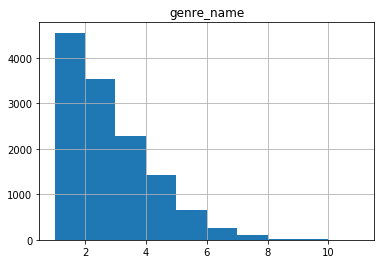

In [10]:
# Number of genres per book
genre_tags.loc[:,['wiki_id', 'genre_name']].groupby('wiki_id').count().hist()

In [11]:
def genres_for_books(wiki_ids):
    return genre_tags.loc[genre_tags['wiki_id'].isin(wiki_ids)]

# Look up multiple books
# genres_for_books(data.wiki_id.iloc[0:3])
# To look up single book wrap in an array
# genres_for_books([data.wiki_id[0]])

In [12]:
def genres_for_author(author):
    books_for_author = data.loc[data['author'] == author].loc[:, 'wiki_id']
    return genres_for_books(books_for_author)

# Look up genres for single author
# genres_for_author('George Orwell')

### Wieviele Autoren haben in wievielen unterschiedlichen Genres publiziert?

In [13]:
authors = data.groupby('author')

author_genres = []
for name, group in authors:
    author_genres += [
        [name, genres_for_books(group.wiki_id).genre_name.unique().size]
    ]

author_genres = pd.DataFrame(author_genres)
author_genres.describe()

,1
count,4714.000000
mean,2.441451
std,2.489543
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,22.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001768066D668>]],
      dtype=object)

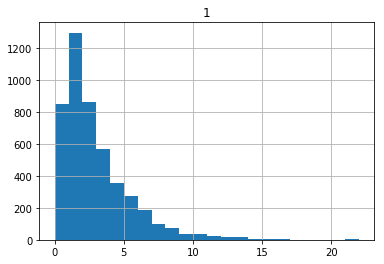

In [14]:
author_genres.hist( bins=22 )

### Wieviele Autoren haben wieviele unterschiedliche Bücher publiziert?

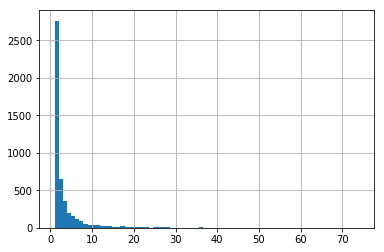

In [15]:
num_titles_per_author=authors.title.nunique()
plt=num_titles_per_author.hist(bins=num_titles_per_author.max())

In [16]:
print(num_titles_per_author.describe())

count    4714.000000
mean        3.006364
std         5.098350
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        74.000000
Name: title, dtype: float64


### Doppelbelegung von Titeln

In [17]:
titles=data.groupby("title")
print('Anzahl der doppelten Titeln:',titles.nunique().loc[titles.nunique().wiki_id > 1].shape)

Anzahl der doppelten Titeln: (246, 7)


In [18]:
titles.nunique().loc[titles.nunique().wiki_id > 1].head()

,wiki_id,firebase_id,title,author,pub_date,genres,plot
title,,,,,,,
1945,2,2,1,2,2,2,2
A Casa,2,2,1,2,0,2,2
A Taste for Death,2,2,1,2,1,2,2
Abduction,2,2,1,2,2,2,2
American Beauty,2,2,1,2,2,1,2


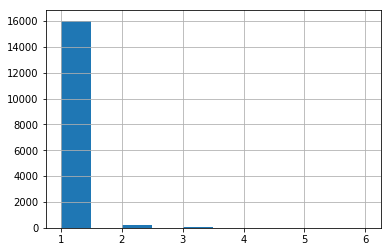

In [25]:
titles.nunique().wiki_id.hist()

## Data Exploration: goodbooks-10k

Basic data exploration of the goodbooks-10k dataset.

In [20]:
# Loading the data
r = pd.read_csv( './datasets/goodbooks-10k/ratings.csv' )
tr = pd.read_csv( './datasets/goodbooks-10k/to_read.csv' )
b = pd.read_csv( './datasets/goodbooks-10k/books.csv' )

t = pd.read_csv( './datasets/goodbooks-10k/tags.csv' )
bt = pd.read_csv( './datasets/goodbooks-10k/book_tags.csv')



### Wieviele Autoren haben wieviele unterschiedliche Bücher publiziert?

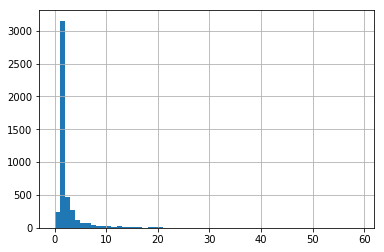

In [21]:
authors_10k=b.groupby('authors')
titles_per_author_10k=authors_10k.original_title.nunique()
plt=titles_per_author_10k.hist(bins=titles_per_author_10k.max())

In [22]:
titles_per_author_10k.describe()

count    4664.000000
mean        2.016509
std         3.314449
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        59.000000
Name: original_title, dtype: float64

## Combining the datasets

In [23]:
merged_data = data.merge(b, left_on="title", right_on="original_title")
merged_data.shape

(2939, 30)